In [43]:
import os
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from skimage.feature import hog
import numpy as np

In [44]:
csv_path = "./train.csv"
image_dir = "./lego/"

df = pd.read_csv(csv_path)
df['file_path'] = df['example_id'].apply(lambda x: os.path.join(image_dir, f'{x}.jpg'))

In [45]:
def extract_features(img_path):
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (128, 128))  # padroniza
    features, _ = hog(image, pixels_per_cell=(16, 16), cells_per_block=(2, 2),
                      orientations=9, visualize=True, feature_vector=True)
    return features

In [46]:
def safe_load_image(img_path):
    image = cv2.imread(img_path)
    if image is None:
        print(f"Error loading image: {img_path}")
        return None
    return image

In [47]:
X = np.array([extract_features(fp) for fp in df['file_path']])
y = df[['no_hat', 'no_face', 'no_head', 'no_leg', 'no_body', 'no_hand', 'no_arm']].values

# Pre processing

In [48]:
def preprocess_image(image_path, resize_shape=(256, 256)):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not load image {image_path}")
        # Return a black dummy image with expected keys to prevent crashes
        dummy = np.zeros((resize_shape[0], resize_shape[1], 3), dtype=np.uint8)
        return {
            "original": dummy,
            "blurred": dummy,
            "gray": np.zeros((resize_shape[0], resize_shape[1]), dtype=np.uint8),
            "hsv": dummy,
            "edges": np.zeros((resize_shape[0], resize_shape[1]), dtype=np.uint8),
            "binary": np.zeros((resize_shape[0], resize_shape[1]), dtype=np.uint8),
        }

    image = cv2.resize(image, resize_shape)

    blurred = cv2.GaussianBlur(image, (5, 5), 0)

    gray = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)

    hsv = cv2.cvtColor(blurred, cv2.COLOR_BGR2HSV)

    edges = cv2.Canny(gray, threshold1=50, threshold2=200)

    _, binary = cv2.threshold(gray, 80, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    return {
        "original": image,
        "blurred": blurred,
        "gray": gray,
        "hsv": hsv,
        "edges": edges,
        "binary": binary,
    }

In [49]:
def show_preprocessing_steps(image_path):
    result = preprocess_image(image_path)

    plt.figure(figsize=(12, 6))

    plt.subplot(2, 3, 1)
    plt.imshow(cv2.cvtColor(result["original"], cv2.COLOR_BGR2RGB))
    plt.title("Original")

    plt.subplot(2, 3, 2)
    plt.imshow(result["gray"], cmap="gray")
    plt.title("Grayscale")

    plt.subplot(2, 3, 3)
    plt.imshow(result["edges"], cmap="gray")
    plt.title("Edges (Canny)")

    plt.subplot(2, 3, 4)
    plt.imshow(result["binary"], cmap="gray")
    plt.title("Binarized")

    plt.subplot(2, 3, 5)
    plt.imshow(cv2.cvtColor(result["hsv"], cv2.COLOR_HSV2RGB))
    plt.title("HSV")

    plt.tight_layout()
    plt.show()

## Recognize the parts

In [50]:
def extract_region_based_features(image_path):
    """Extract features from specific regions of the image relevant to each defect type"""
    processed = preprocess_image(image_path)
    image = processed['original']
    binary = processed['binary']
    edges = processed['edges']
    
    # Better region definitions with smaller, more focused areas
    height, width = image.shape[:2]
    
    # Adjusted region definitions
    hat_region = binary[0:height//5, width//3:2*width//3]  # Focus on center top
    head_region = binary[height//6:height//3, width//3:2*width//3]  # Center head
    face_region = binary[height//6:height//3, 2*width//5:3*width//5]  # Center face
    body_region = binary[height//3:2*height//3, width//3:2*width//3]  # Center body]
    
    # Extract features from each region
    features = {}
    
    # Hat detection - check for presence of pixels in top region
    features['hat_pixels'] = np.sum(hat_region) / hat_region.size
    
    # Head detection - check for circle-like shape
    head_contours, _ = cv2.findContours(head_region, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    features['head_contour_count'] = len(head_contours)
    features['head_area'] = np.sum(head_region) / head_region.size if head_contours else 0
    
    # Face detection - check for facial features using edge detection
    features['face_edge_density'] = np.sum(edges[height//6:height//3, width//3:2*width//3]) / face_region.size
    
    # Body detection - check for texture in body region using variance in color
    hsv = processed['hsv']
    body_hsv = hsv[height//3:2*height//3, :]
    features['body_saturation_variance'] = np.var(body_hsv[:,:,1])
    features['body_value_variance'] = np.var(body_hsv[:,:,2])
    
    # Leg detection - check for presence and symmetry of legs
    left_leg = binary[2*height//3:, :width//2]
    right_leg = binary[2*height//3:, width//2:]
    features['left_leg_pixels'] = np.sum(left_leg) / left_leg.size
    features['right_leg_pixels'] = np.sum(right_leg) / right_leg.size
    features['leg_symmetry'] = abs(features['left_leg_pixels'] - features['right_leg_pixels'])
    
    # Arm detection - check for horizontal protrusions from body
    left_arm = binary[height//3:2*height//3, :width//4]
    right_arm = binary[height//3:2*height//3, 3*width//4:]
    features['left_arm_pixels'] = np.sum(left_arm) / left_arm.size
    features['right_arm_pixels'] = np.sum(right_arm) / right_arm.size
    
    # Convert dictionary to flat array
    return np.array(list(features.values()))

In [ ]:
def detect_defects(image_path):
    """Improved rule-based defect detection with better thresholds"""
    try:
        features = extract_region_based_features(image_path)
        processed = preprocess_image(image_path)

        if len(features) < 12:
            print(f"Error: Insufficient features extracted from {image_path}")
            features = np.pad(features, (0, max(0, 12 - len(features))), 'constant')
        
        # Recalibrated thresholds based on problematic examples
        defects = {
            'no_hat': features[0] < 0.15,  # Increased sensitivity for hat detection
            'no_face': features[3] < 0.05,  # Current face detection seems to work
            'no_head': features[1] < 2 and features[2] < 0.15,  # Relaxed head detection
            'no_leg': features[7] < 0.2 or features[8] < 0.2,  # Detect if either leg is missing
            'no_body': features[5] < 0.2 and features[6] < 0.2,  # More sensitive body detection
            'no_hand': False,  # Will be set later
            'no_arm': features[10] < 0.1 or features[11] < 0.1  # Detect if either arm is missing
        }
        
        # Hand detection with more sensitivity
        height, width = processed['original'].shape[:2]
        left_arm_tip = processed['binary'][height//3:2*height//3, :width//6]
        right_arm_tip = processed['binary'][height//3:2*height//3, 5*width//6:]
        
        left_hand_missing = np.sum(left_arm_tip) / left_arm_tip.size < 0.12
        right_hand_missing = np.sum(right_arm_tip) / right_arm_tip.size < 0.12
        defects['no_hand'] = left_hand_missing or right_hand_missing
        
        return defects
    except Exception as e:
        print(f"Error processing {image_path}: {str(e)}")
        return {'no_hat': False, 'no_face': False, 'no_head': False, 
                'no_leg': False, 'no_body': False, 'no_hand': False, 'no_arm': False}

In [52]:
def evaluate_rules_on_training():
    results = []
    
    for i, row in df.iterrows():
        img_path = row['file_path']
        actual_defects = row[['no_hat', 'no_face', 'no_head', 'no_leg', 'no_body', 'no_hand', 'no_arm']]
        
        # Detect defects using our rules
        detected = detect_defects(img_path)
        predicted_defects = [detected[key] for key in ['no_hat', 'no_face', 'no_head', 'no_leg', 'no_body', 'no_hand', 'no_arm']]
        
        # Calculate accuracy for this image
        correct = sum(1 for a, p in zip(actual_defects, predicted_defects) if a == p)
        accuracy = correct / len(actual_defects)
        
        results.append({
            'example_id': row['example_id'],
            'accuracy': accuracy,
            'actual': list(actual_defects),
            'predicted': predicted_defects
        })
    
    return pd.DataFrame(results)

In [53]:
def visualize_defect_detection(image_path):
    """Visualize the regions and detection results for debugging"""
    processed = preprocess_image(image_path)
    defects = detect_defects(image_path)
    
    # Create a visualization
    height, width = processed['original'].shape[:2]
    visualization = processed['original'].copy()
    
    # Draw regions
    # Hat region
    cv2.rectangle(visualization, (width//3, 0), (2*width//3, height//5), (255,0,0), 2)
    # Head region
    cv2.rectangle(visualization, (width//3, height//6), (2*width//3, height//3), (0,255,0), 2)
    # Face region
    cv2.rectangle(visualization, (2*width//5, height//6), (3*width//5, height//3), (0,255,255), 2)
    # Body region
    cv2.rectangle(visualization, (width//3, height//3), (2*width//3, 2*height//3), (0,0,255), 2)
    # Leg regions
    cv2.rectangle(visualization, (0, 2*height//3), (width//2, height), (255,0,255), 2)  # left leg
    cv2.rectangle(visualization, (width//2, 2*height//3), (width, height), (255,0,255), 2)  # right leg
    # Arm regions
    cv2.rectangle(visualization, (0, height//3), (width//4, 2*height//3), (255,255,0), 2)  # left arm
    cv2.rectangle(visualization, (3*width//4, height//3), (width, 2*height//3), (255,255,0), 2)  # right arm
    
    # Display results
    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(visualization, cv2.COLOR_BGR2RGB))
    plt.title(f"Defects: {', '.join([k for k, v in defects.items() if v])}")
    plt.show()
    
    return defects

In [54]:
def optimize_thresholds():
    """Find optimal thresholds by testing different combinations"""
    # Define threshold ranges to test
    hat_thresholds = [0.05, 0.1, 0.15, 0.2]
    face_thresholds = [0.03, 0.05, 0.07, 0.1]
    head_thresholds = [1, 2, 3]
    head_area_thresholds = [0.1, 0.15, 0.2]
    leg_thresholds = [0.1, 0.15, 0.2, 0.25]
    body_thresholds = [0.1, 0.15, 0.2, 0.25]
    arm_thresholds = [0.05, 0.1, 0.15]
    
    best_accuracy = 0
    best_thresholds = {}
    
    # We'll use a simpler approach to avoid testing all combinations
    # First test individual thresholds
    
    print("Optimizing hat threshold...")
    for hat_t in hat_thresholds:
        correct = 0
        total = 0
        for i, row in df.iterrows():
            img_path = row['file_path']
            features = extract_region_based_features(img_path)
            no_hat_pred = features[0] < hat_t
            no_hat_true = row['no_hat']
            correct += 1 if no_hat_pred == no_hat_true else 0
            total += 1
        accuracy = correct / total
        print(f"  Hat threshold {hat_t}: Accuracy = {accuracy:.4f}")
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_thresholds['hat'] = hat_t

    print("Optimizing face threshold...")
    for face_t in face_thresholds:
        correct = 0
        total = 0
        for i, row in df.iterrows():
            img_path = row['file_path']
            features = extract_region_based_features(img_path)
            no_face_pred = features[3] < face_t
            no_face_true = row['no_face']
            correct += 1 if no_face_pred == no_face_true else 0
            total += 1
        accuracy = correct / total
        print(f"  Face threshold {face_t}: Accuracy = {accuracy:.4f}")
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_thresholds['face'] = face_t

    print("Optimizing head threshold...")
    for head_t in head_thresholds:
        correct = 0
        total = 0
        for i, row in df.iterrows():
            img_path = row['file_path']
            features = extract_region_based_features(img_path)
            no_head_pred = features[1] < head_t and features[2] < 0.15
            no_head_true = row['no_head']
            correct += 1 if no_head_pred == no_head_true else 0
            total += 1
        accuracy = correct / total
        print(f"  Head threshold {head_t}: Accuracy = {accuracy:.4f}")
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_thresholds['head'] = head_t

    print("Optimizing head area threshold...")
    for head_area_t in head_area_thresholds:
        correct = 0
        total = 0
        for i, row in df.iterrows():
            img_path = row['file_path']
            features = extract_region_based_features(img_path)
            no_head_pred = features[1] < 2 and features[2] < head_area_t
            no_head_true = row['no_head']
            correct += 1 if no_head_pred == no_head_true else 0
            total += 1
        accuracy = correct / total
        print(f"  Head area threshold {head_area_t}: Accuracy = {accuracy:.4f}")
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_thresholds['head_area'] = head_area_t
        
    print("Optimizing leg threshold...")

    for leg_t in leg_thresholds:
        correct = 0
        total = 0
        for i, row in df.iterrows():
            img_path = row['file_path']
            features = extract_region_based_features(img_path)
            no_leg_pred = features[7] < leg_t or features[8] < leg_t
            no_leg_true = row['no_leg']
            correct += 1 if no_leg_pred == no_leg_true else 0
            total += 1
        accuracy = correct / total
        print(f"  Leg threshold {leg_t}: Accuracy = {accuracy:.4f}")
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_thresholds['leg'] = leg_t
    
    print("Optimizing body threshold...")
    for body_t in body_thresholds:
        correct = 0
        total = 0
        for i, row in df.iterrows():
            img_path = row['file_path']
            features = extract_region_based_features(img_path)
            no_body_pred = features[5] < body_t and features[6] < body_t
            no_body_true = row['no_body']
            correct += 1 if no_body_pred == no_body_true else 0
            total += 1
        accuracy = correct / total
        print(f"  Body threshold {body_t}: Accuracy = {accuracy:.4f}")
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_thresholds['body'] = body_t
    
    print("Optimizing arm threshold...")
    for arm_t in arm_thresholds:
        correct = 0
        total = 0
        for i, row in df.iterrows():
            img_path = row['file_path']
            features = extract_region_based_features(img_path)
            no_arm_pred = features[10] < arm_t or features[11] < arm_t
            no_arm_true = row['no_arm']
            correct += 1 if no_arm_pred == no_arm_true else 0
            total += 1
        accuracy = correct / total
        print(f"  Arm threshold {arm_t}: Accuracy = {accuracy:.4f}")
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_thresholds['arm'] = arm_t

    print("\nBest thresholds found:")
    for key, value in best_thresholds.items():
        print(f"  {key}: {value}")
    
    return best_thresholds


In [ ]:
def detect_parts_by_color(hsv_image):
    """Detect Lego parts based on color signatures"""
    # Define color ranges for different parts
    hat_color_lower = np.array([...])  # HSV range for hat color
    hat_color_upper = np.array([...])
    
    # Create masks for each part
    hat_mask = cv2.inRange(hsv_image, hat_color_lower, hat_color_upper)
    
    # Calculate part presence based on color masks
    # ...

In [ ]:
def detect_lego_figure(binary_image):
    """Find the main Lego figure in the image and its bounding box"""
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Find the largest contour (likely the Lego figure)
    if contours:
        main_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(main_contour)
        return True, (x, y, w, h)
    
    return False, (0, 0, 0, 0)

In [ ]:
def extract_adaptive_features(image_path):
    """Extract features with adaptive regions based on figure detection"""
    processed = preprocess_image(image_path)
    binary = processed['binary']
    
    # Find the Lego figure
    found, (x, y, w, h) = detect_lego_figure(binary)
    if not found:
        print(f"Warning: Could not detect Lego figure in {image_path}")
        return np.zeros(12)  # Return zeros if no figure found
    
    # Define regions relative to detected figure
    hat_region = binary[y:y+h//5, x+w//4:x+3*w//4]
    head_region = binary[y+h//6:y+h//3, x+w//3:x+2*w//3]
    # Define other regions similarly...
    arm_region = binary[y+h//3:y+2*h//3, x:x+w//4]
    leg_region = binary[y+2*h//3:y+h, x:x+w//2]
    hand_region = binary[y+h//3:y+2*h//3, x+w//4:x+3*w//4]
    


    # Extract features from these adaptive regions
    features = {}
    # Feature extraction logic...
    
    return np.array(list(features.values()))

In [55]:
def process_test_and_create_submission():
    test_csv_path = "./test.csv"
    test_df = pd.read_csv(test_csv_path)
    test_df['file_path'] = test_df['example_id'].apply(lambda x: os.path.join(image_dir, f'{x}.jpg'))
    
    results = []
    
    for i, row in test_df.iterrows():
        img_path = row['file_path']
        defects = detect_defects(img_path)
        
        results.append({
            'example_id': row['example_id'],
            'no_hat': int(defects['no_hat']),
            'no_face': int(defects['no_face']),
            'no_head': int(defects['no_head']),
            'no_leg': int(defects['no_leg']),
            'no_body': int(defects['no_body']),
            'no_hand': int(defects['no_hand']),
            'no_arm': int(defects['no_arm'])
        })
    
    submission_df = pd.DataFrame(results)
    submission_df['has_deffect'] = submission_df[['no_hat', 'no_face', 'no_head', 'no_leg', 
                                                'no_body', 'no_hand', 'no_arm']].any(axis=1).astype(int)
    
    submission_df.to_csv('submission.csv', index=False)
    return submission_df

Step 1: Loading training data...

Step 2: Visualizing sample images...
Visualizing: ./lego/vjpmaydgs.jpg


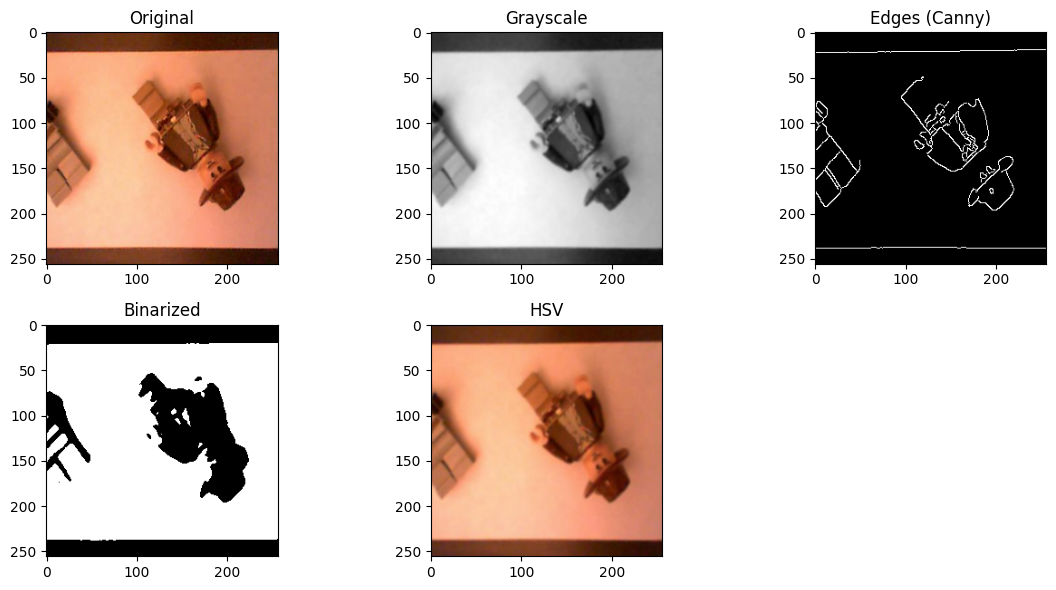

Visualizing: ./lego/pmvgdjsya.jpg


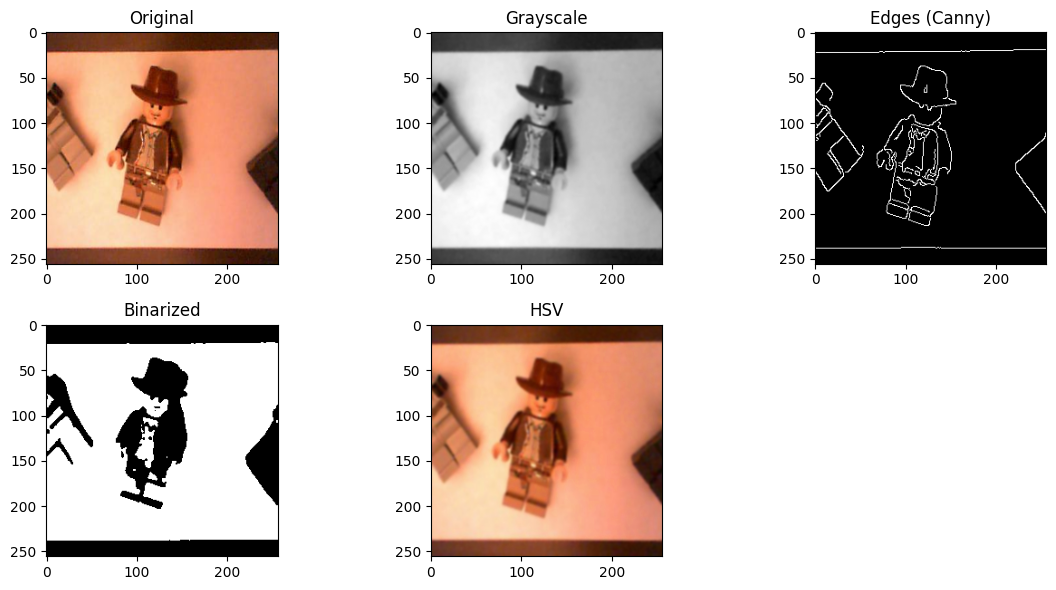

Visualizing: ./lego/gmvasyjdp.jpg


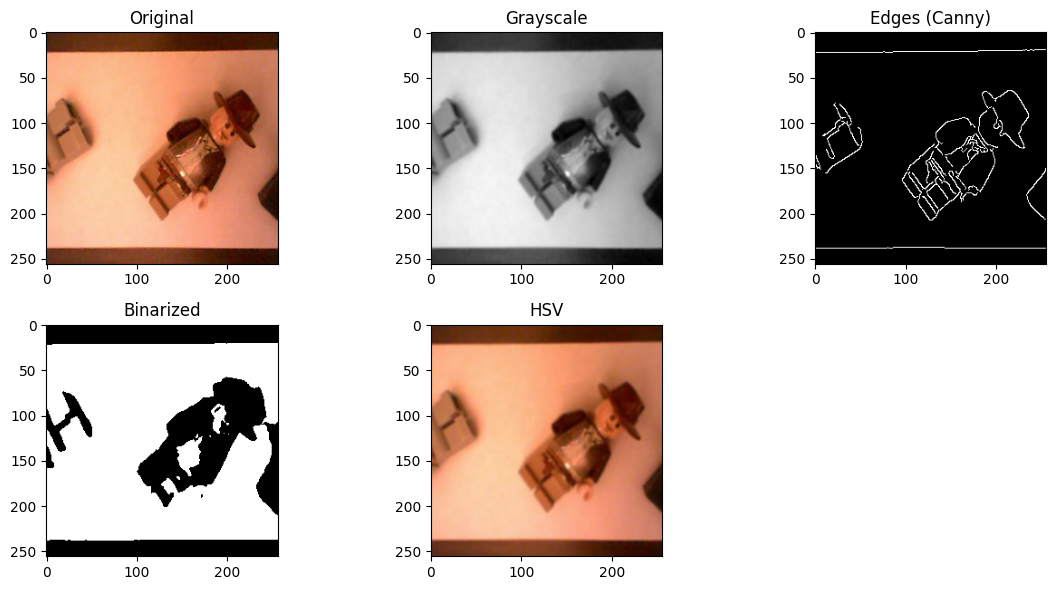


Step 3: Evaluating rule performance on training data...
Error: Insufficient features extracted from ./lego/adsyjmgvp.jpg
Error: Insufficient features extracted from ./lego/agmpdjsyv.jpg
Error: Insufficient features extracted from ./lego/ajgyvdsmp.jpg
Error: Insufficient features extracted from ./lego/ajsdmvypg.jpg
Error: Insufficient features extracted from ./lego/apmjvdgys.jpg
Error: Insufficient features extracted from ./lego/apsjdmgyv.jpg
Error: Insufficient features extracted from ./lego/avdmyspjg.jpg
Error: Insufficient features extracted from ./lego/aymdvsgjp.jpg
Error: Insufficient features extracted from ./lego/damgvpyjs.jpg
Error: Insufficient features extracted from ./lego/dapysjvmg.jpg
Error: Insufficient features extracted from ./lego/dgpmysvja.jpg
Error: Insufficient features extracted from ./lego/djmygaspv.jpg
Error: Insufficient features extracted from ./lego/djpamsvyg.jpg
Error: Insufficient features extracted from ./lego/djsyamvpg.jpg
Error: Insufficient features extr

In [56]:
def run_complete_pipeline():
    """Run the complete pipeline for Lego defect detection"""
    print("Step 1: Loading training data...")
    # This is already done in your earlier cells
    
    # Optional: Visualize some sample images to verify preprocessing
    print("\nStep 2: Visualizing sample images...")
    # Randomly select a few images to visualize
    sample_images = df.sample(3)['file_path'].tolist()
    for img_path in sample_images:
        print(f"Visualizing: {img_path}")
        show_preprocessing_steps(img_path)
    
    # Evaluate rule performance on training data
    print("\nStep 3: Evaluating rule performance on training data...")
    eval_results = evaluate_rules_on_training()
    
    # Display summary statistics
    avg_accuracy = eval_results['accuracy'].mean()
    print(f"Average accuracy across all training images: {avg_accuracy:.4f}")
    
    # Identify problematic cases
    problem_cases = eval_results[eval_results['accuracy'] < 0.7]
    print(f"Found {len(problem_cases)} problematic cases with accuracy < 70%")
    
    if len(problem_cases) > 0:
        print("Top problematic examples:")
        for _, row in problem_cases.head(3).iterrows():
            print(f"  ID: {row['example_id']}, Accuracy: {row['accuracy']:.4f}")
            print(f"  Actual defects: {row['actual']}")
            print(f"  Predicted defects: {row['predicted']}")
    
    # Process test data and create submission
    print("\nStep 4: Processing test data and creating submission...")
    submission = process_test_and_create_submission()
    print(f"Submission file created with {len(submission)} entries")
    
    # Show defect statistics in submission
    defect_counts = {
        'no_hat': submission['no_hat'].sum(),
        'no_face': submission['no_face'].sum(),
        'no_head': submission['no_head'].sum(),
        'no_leg': submission['no_leg'].sum(), 
        'no_body': submission['no_body'].sum(),
        'no_hand': submission['no_hand'].sum(),
        'no_arm': submission['no_arm'].sum(),
    }
    print("\nDefect statistics in test set:")
    for defect, count in defect_counts.items():
        print(f"  {defect}: {count} images ({count/len(submission)*100:.1f}%)")
    
    print(f"Total compliant images: {len(submission) - submission['has_deffect'].sum()}")
    print(f"Total non-compliant images: {submission['has_deffect'].sum()}")
    
    return submission, eval_results

# Execute the pipeline
submission, evaluation = run_complete_pipeline()

Analyzing image: ./lego/agmpdjsyv.jpg
Error: Insufficient features extracted from ./lego/agmpdjsyv.jpg


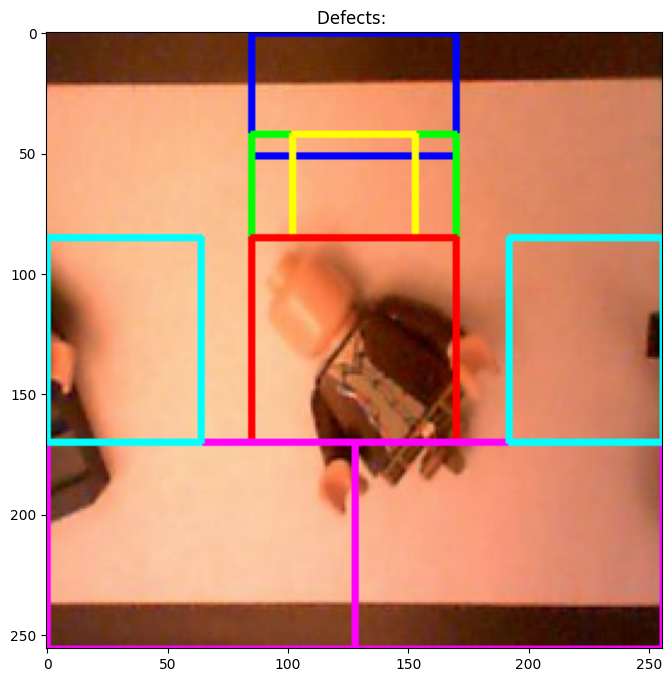

Analyzing image: ./lego/avdmyspjg.jpg
Error: Insufficient features extracted from ./lego/avdmyspjg.jpg


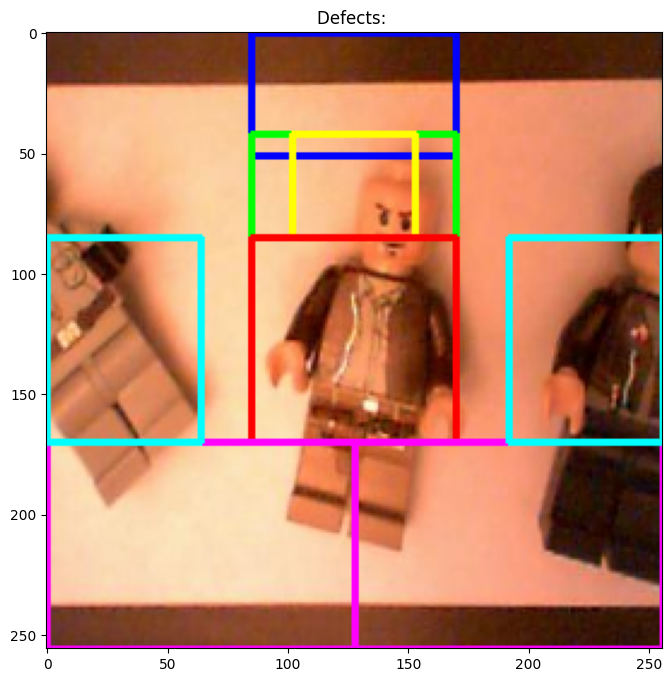

Analyzing image: ./lego/djsyamvpg.jpg
Error: Insufficient features extracted from ./lego/djsyamvpg.jpg


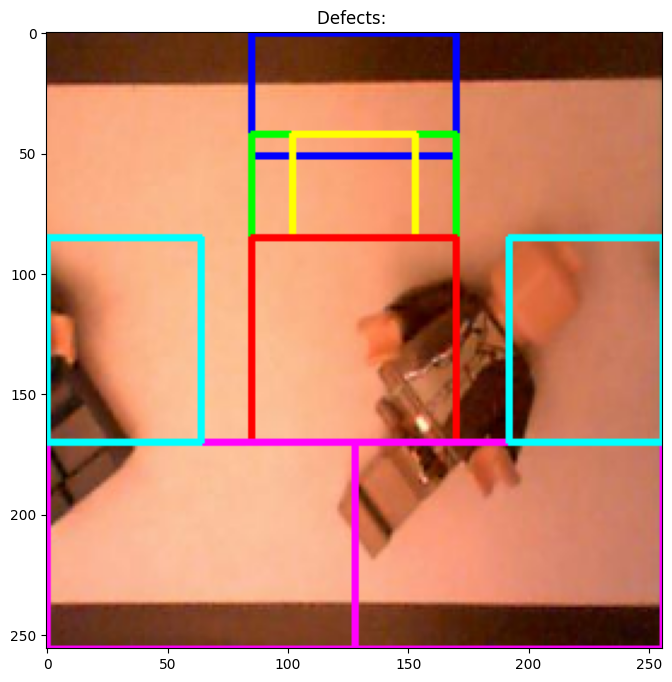

Finding optimal thresholds for all defect types...
Optimizing hat threshold...
  Hat threshold 0.05: Accuracy = 0.8000
  Hat threshold 0.1: Accuracy = 0.8000
  Hat threshold 0.15: Accuracy = 0.8000
  Hat threshold 0.2: Accuracy = 0.8000
Optimizing face threshold...
  Face threshold 0.03: Accuracy = 0.7333
  Face threshold 0.05: Accuracy = 0.7333
  Face threshold 0.07: Accuracy = 0.7333
  Face threshold 0.1: Accuracy = 0.7333
Optimizing head threshold...
  Head threshold 1: Accuracy = 0.9556
  Head threshold 2: Accuracy = 0.9556
  Head threshold 3: Accuracy = 0.9556
Optimizing head area threshold...
  Head area threshold 0.1: Accuracy = 0.9556
  Head area threshold 0.15: Accuracy = 0.9556
  Head area threshold 0.2: Accuracy = 0.9556
Optimizing leg threshold...
  Leg threshold 0.1: Accuracy = 0.8556
  Leg threshold 0.15: Accuracy = 0.8556
  Leg threshold 0.2: Accuracy = 0.8556
  Leg threshold 0.25: Accuracy = 0.8556
Optimizing body threshold...
  Body threshold 0.1: Accuracy = 0.9111
  B

IndexError: index 11 is out of bounds for axis 0 with size 11

In [57]:
# Step 1: Visualize a few problematic examples
problem_cases = df[df['no_hat'] == 1].head(3)['file_path'].tolist()
for img_path in problem_cases:
    print(f"Analyzing image: {img_path}")
    visualize_defect_detection(img_path)

# Step 2: Find optimal thresholds
print("Finding optimal thresholds for all defect types...")
best_thresholds = optimize_thresholds()

# Step 3: Implement the improved detection function with optimized thresholds
def detect_defects_optimized(image_path):
    """Defect detection with optimized thresholds"""
    features = extract_region_based_features(image_path)
    processed = preprocess_image(image_path)
    
    # Use optimized thresholds if available
    defects = {
        'no_hat': features[0] < best_thresholds.get('hat', 0.15),  
        'no_face': features[3] < best_thresholds.get('face', 0.05),
        'no_head': features[1] < best_thresholds.get('head', 2) and features[2] < best_thresholds.get('head_area', 0.15),
        'no_leg': features[7] < best_thresholds.get('leg', 0.2) or features[8] < best_thresholds.get('leg', 0.2),
        'no_body': features[5] < best_thresholds.get('body', 0.2) and features[6] < best_thresholds.get('body', 0.2),
        'no_hand': False,  # Will be set later
        'no_arm': features[10] < best_thresholds.get('arm', 0.1) or features[11] < best_thresholds.get('arm', 0.1)
    }
    
    # Hand detection with more sensitivity
    height, width = processed['original'].shape[:2]
    left_arm_tip = processed['binary'][height//3:2*height//3, :width//6]
    right_arm_tip = processed['binary'][height//3:2*height//3, 5*width//6:]
    
    left_hand_missing = np.sum(left_arm_tip) / left_arm_tip.size < 0.12
    right_hand_missing = np.sum(right_arm_tip) / right_arm_tip.size < 0.12
    defects['no_hand'] = left_hand_missing or right_hand_missing
    
    return defects

# Step 4: Override the original detect_defects function
detect_defects = detect_defects_optimized

# Step 5: Re-run evaluation to check improvement
eval_results = evaluate_rules_on_training()
print(f"Average accuracy with optimized thresholds: {eval_results['accuracy'].mean():.4f}")